In [1]:
import torch 

import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data and Dataloaders

In [3]:
data_path = Path('../data')
data_path.mkdir(exist_ok=True)

In [4]:
dataset = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

Files already downloaded and verified


In [5]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
train_dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

In [9]:
for Xtr, ytr in train_dataloader:
    x_train, y_train = Xtr.to(device), ytr.to(device)
    print(x_train.shape, y_train.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


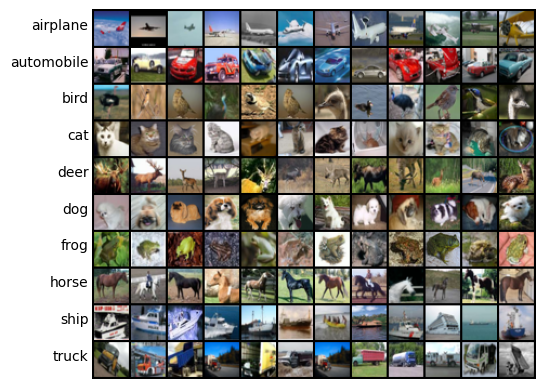

In [11]:
# visualization on train dataset

import random
from torchvision.utils import make_grid

classes = dataset.classes
samples_per_class = 12
samples = []
    
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs = (y_train == y).nonzero().view(-1)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
        
img = make_grid(samples, nrow=samples_per_class).cpu()
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Subsampling data for experimentation

In [12]:
# x_train = x_train[:5000]
# y_train = y_train[:5000]

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])


## Implementation of KNN

In [25]:
class KnnClassifier:
    def __init__(self, x_train, y_train):
        """
        Create a new K-Nearest Neighbor classifier with the specified training data.
        In the initializer we simply memorize the provided training data.

        Inputs:
        - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
        - y_train: int64 torch tensor of shape (num_train,) giving training labels
        """
        
        self.num_train = x_train.shape[0]
        self.x_train = x_train.reshape(self.num_train, -1).contiguous()
        self.y_train = y_train.contiguous()
        
        
    def predict(self, x_test, k=1):
        """
        Make predictions using the classifier.

        Inputs:
        - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
        - k: The number of neighbors to use for predictions

        Returns:
        - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
            for the test samples.
        """
        self.num_test = x_test.shape[0]
        self.x_test = x_test.reshape(self.num_test, -1).contiguous()
        
        def predict_labels(dists, y_test, k=1):
            y_pred = torch.zeros(self.num_test, dtype=torch.int64).to(device)
            for i in range(self.num_test):
                _, indices = torch.topk(dists[i], k=k, largest=False)
                neighbor_labels = y_test[indices]
                counts = torch.bincount(neighbor_labels)
                max_counts = torch.max(counts)
                max_labels = torch.nonzero(counts == max_counts).flatten()
                
                if len(max_labels) > 1:
                    y_pred[i] = max_labels.min().item()
                else:
                    y_pred[i] = max_labels.item()
            return y_pred

        
        dists = torch.cdist(self.x_test, self.x_train)
        y_pred = predict_labels(dists, self.y_train, k=k)
        
        return y_pred
  
    def check_accuracy(self, x_test, y_test, k=1, quiet=False):
        """
        Utility method for checking the accuracy of this classifier on test data.
        Returns the accuracy of the classifier on the test data, and also prints a
        message giving the accuracy.

        Inputs:
        - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
        - y_test: int64 torch tensor of shape (num_test,) giving test labels
        - k: The number of neighbors to use for prediction
        - quiet: If True, don't print a message.

        Returns:
        - accuracy: Accuracy of this classifier on the test data, as a percent.
            Python float in the range [0, 100]
        """
        y_test = y_test
        y_pred = self.predict(x_test, k=k)
        num_samples = self.num_test
        num_correct = (y_test == y_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        
        if not quiet:
            print(f'Got {num_correct} / {num_samples} correct; Accuracy is {accuracy:.2f}%')
            
        return accuracy

## Cross Validation

In [26]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None, quiet=False):
    """
    Perform cross-validation for KnnClassifier.

    Inputs:
    - x_train: Tensor of shape (num_train, C, H, W) giving all training data
    - y_train: int64 tensor of shape (num_train,) giving labels for training data
    - num_folds: Integer giving the number of folds to use
    - k_choices: List of integers giving the values of k to try
    - quiet: If True, don't print a message.

    Returns:
    - k_to_accuracies: Dictionary mapping values of k to lists, where
    k_to_accuracies[k][i] is the accuracy on the ith fold of a KnnClassifier
    that uses k nearest neighbors.
    """
    if k_choices is None:
        # Use default values
        k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

    x_train_folds = torch.chunk(x_train, num_folds)
    y_train_folds = torch.chunk(y_train, num_folds)

    k_to_accuracies = {}
    for k in k_choices:
        k_to_accuracies[k] = []
        print(f"k = {k}: ")
        
        for i in range(num_folds):
            x_train = torch.cat(x_train_folds[:i] + x_train_folds[i+1:])
            y_train = torch.cat(y_train_folds[:i] + y_train_folds[i+1:])
            
            x_test = x_train_folds[i]
            y_test = y_train_folds[i]
            
            model = KnnClassifier(x_train, y_train)
            accuracy = model.check_accuracy(x_test, y_test, k=k, quiet=quiet)
            
            k_to_accuracies[k].append(accuracy)
            
    return k_to_accuracies

In [27]:
k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
    print('k = %d got accuracies: %r' % (k, accs))

k = 1: 
Got 3403 / 10000 correct; Accuracy is 34.03%
Got 3418 / 10000 correct; Accuracy is 34.18%
Got 3341 / 10000 correct; Accuracy is 33.41%
Got 3423 / 10000 correct; Accuracy is 34.23%
Got 3381 / 10000 correct; Accuracy is 33.81%
k = 3: 
Got 3286 / 10000 correct; Accuracy is 32.86%
Got 3188 / 10000 correct; Accuracy is 31.88%
Got 3202 / 10000 correct; Accuracy is 32.02%
Got 3226 / 10000 correct; Accuracy is 32.26%
Got 3255 / 10000 correct; Accuracy is 32.55%
k = 5: 
Got 3324 / 10000 correct; Accuracy is 33.24%
Got 3272 / 10000 correct; Accuracy is 32.72%
Got 3234 / 10000 correct; Accuracy is 32.34%
Got 3333 / 10000 correct; Accuracy is 33.33%
Got 3324 / 10000 correct; Accuracy is 33.24%
k = 8: 
Got 3400 / 10000 correct; Accuracy is 34.00%
Got 3307 / 10000 correct; Accuracy is 33.07%
Got 3230 / 10000 correct; Accuracy is 32.30%
Got 3358 / 10000 correct; Accuracy is 33.58%
Got 3372 / 10000 correct; Accuracy is 33.72%
k = 10: 
Got 3352 / 10000 correct; Accuracy is 33.52%
Got 3284 / 100

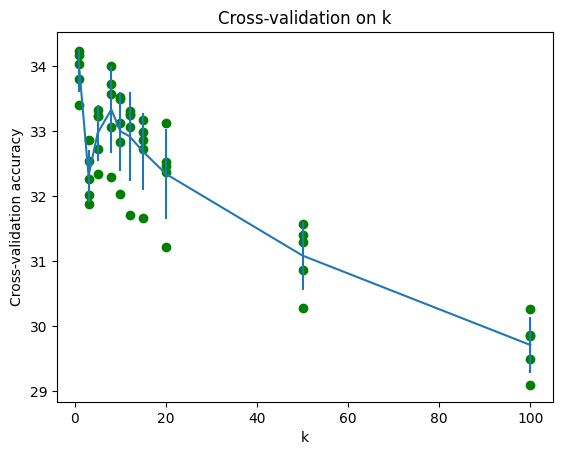

In [28]:
ks, means, stds = [], [], []
for k, accs in sorted(k_to_accuracies.items()):
    plt.scatter([k] * len(accs), accs, color='g')
    ks.append(k)
    means.append(torch.tensor(accs).mean())
    stds.append(torch.tensor(accs).std())

plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

In [31]:
best_k = ks[torch.tensor(means).argmax()]
best_k

1

## Evaluation

In [36]:
test_dataset = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

for Xte, yte in test_dataloader:
    x_test, y_test = Xte.to(device), yte.to(device)
    print(Xte.shape, yte.shape)

Files already downloaded and verified
torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [37]:
model = KnnClassifier(x_train, y_train)

model.check_accuracy(x_test, y_test, k=best_k)

Got 3541 / 10000 correct; Accuracy is 35.41%


35.41